# Density Estimation with Adaptative RFF and DMKDE quantum circuit in quantum simulator

## Libraries

In [1]:
!pip install qiskit
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 6.1 MB/s 
     |████████████████████████████████| 18.0 MB 161 kB/s 
     |████████████████████████████████| 240 kB 18.0 MB/s 
     |████████████████████████████████| 198 kB 46.5 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 112 kB 49.8 MB/s 
     |████████████████████████████████| 1.6 MB 38.5 MB/s 
     |████████████████████████████████| 37.5 MB 4.5 MB/s 
     |████████████████████████████████| 943 kB 19.3 MB/s 
     |████████████████████████████████| 49 kB 3.9 MB/s 
     |████████████████████████████████| 49 kB 2.9 MB/s 
     |████████████████████████████████| 38.1 MB 62.2 MB/s 
     |████████████████████████████████| 4.0 MB 8.9 MB/s 
     |████████████████████████████████| 112 kB 52.5 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.2-py3-none-any.whl size=11933 sha256=f047dcecd5

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit import QuantumCircuit, Aer, execute
from qiskit.extensions import Initialize
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import StatevectorSimulator
import tensorflow as tf

import numpy as np
backend = Aer.get_backend('qasm_simulator')

## Clone the QMC from GitHUB

In [3]:
!pip install git+https://github.com/fagonzalezo/qmc.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fagonzalezo/qmc.git to /tmp/pip-req-build-718702nv
  Running command git clone -q https://github.com/fagonzalezo/qmc.git /tmp/pip-req-build-718702nv
  Created wheel for qmc: filename=qmc-0.0.1-py3-none-any.whl size=12757 sha256=bb8286974afae88a2c8bcaea7fb3d5c8c284ffd0fb4226a7fe007d1771466606
  Stored in directory: /tmp/pip-ephem-wheel-cache-1qpfxf24/wheels/b2/d2/8d/5870208920445c46dfe694f549251e5f63d7afbee56c01f720
Successfully built qmc


In [4]:
import tensorflow as tf
import numpy as np
import qmc.tf.layers as layers
import qmc.tf.models as models
import matplotlib.pyplot as plt
from time import time

from scipy.stats import norm


## Mount Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## One dimensional approximation

2.0


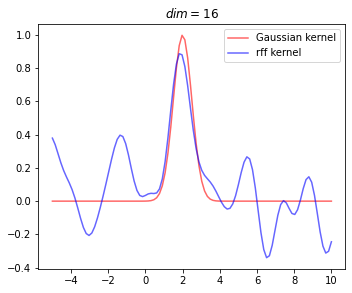

In [20]:
import pylab as pl
from sklearn.kernel_approximation import RBFSampler

def rff_map(x, gamma, n_components, random_state=0):
    rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=random_state)
    return rbf_feature.fit_transform(x)

def gauss_kernel(x, y, gamma):
    return np.exp(-gamma * (x - y) ** 2)

mean = np.array([[2.]])
sigma = 0.5
gamma = 1/(2 * sigma ** 2)
print(gamma)

n_rffs = 16
x = np.linspace(-5.,10.,100)[:, np.newaxis]
x_rff = rff_map(x, gamma, n_rffs)
mean_rff = rff_map(mean, gamma, n_rffs)
gauss_pdf = gauss_kernel(x, mean[0, 0], gamma)
rff_pdf = x_rff @ mean_rff.T
pl.plot(x, gauss_pdf, 'r-',  alpha=0.6, label='Gaussian kernel')
pl.plot(x, rff_pdf, 'b-',  alpha=0.6, label='rff kernel')
pl.title("$dim = "+str(n_rffs)+"$")
pl.legend()

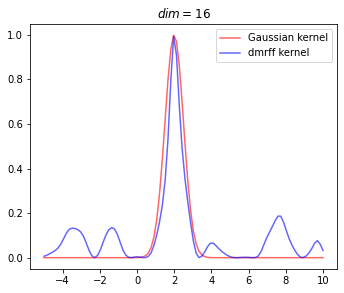

In [21]:
import tensorflow as tf

class QFeatureMapAdaptRFF(layers.QFeatureMapRFF):
    def __init__(
                 self,
                 gamma_trainable=True,
                 weights_trainable=True,
                 **kwargs
                 ):
        self.g_trainable = gamma_trainable
        self.w_trainable = weights_trainable
        super().__init__(**kwargs)

    def build(self, input_shape):
        rbf_sampler = RBFSampler(
            gamma=0.5,
            n_components=self.dim,
            random_state=self.random_state)
        x = np.zeros(shape=(1, self.input_dim))
        rbf_sampler.fit(x)
        self.gamma_val = tf.Variable(
            initial_value=self.gamma,
            dtype=tf.float32,
            trainable=self.g_trainable,
            name="rff_gamma")
        self.rff_weights = tf.Variable(
            initial_value=rbf_sampler.random_weights_,
            dtype=tf.float32,
            trainable=self.w_trainable,
            name="rff_weights")
        self.offset = tf.Variable(
            initial_value=rbf_sampler.random_offset_,
            dtype=tf.float32,
            trainable=self.w_trainable,
            name="offset")
        self.built = True

    def call(self, inputs):
        vals = tf.sqrt(2 * self.gamma_val) * tf.matmul(inputs, self.rff_weights) + self.offset # original code
        vals = tf.cos(vals)
        vals = vals * tf.sqrt(2. / self.dim)
        norms = tf.linalg.norm(vals, axis=-1)
        psi = vals / tf.expand_dims(norms, axis=-1)
        return psi

class DMRFF(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 num_rff,
                 gamma=1,
                 random_state=None):
        super().__init__()
        self.rff_layer = QFeatureMapAdaptRFF(input_dim=dim_x, dim=num_rff, gamma=gamma, random_state=random_state, gamma_trainable=False) #old framework 

    def call(self, inputs):
        x1 = inputs[:, 0]
        x2 = inputs[:, 1]
        phi1 = self.rff_layer(x1)
        phi2 = self.rff_layer(x2)
        dot = tf.einsum('...i,...i->...', phi1, phi2) ** 2
        return dot

def calc_rbf(dmrff, x1, x2):
    return dmrff.predict(np.concatenate([x1[:, np.newaxis, ...], 
                                         x2[:, np.newaxis, ...]], 
                                        axis=1),
                         batch_size=256)

dmrff = DMRFF(dim_x=1, num_rff=n_rffs, gamma=gamma / 2, random_state=np.random.randint(10000))
dm_rff_pdf = calc_rbf(dmrff, np.broadcast_to(mean, x.shape), x)
pl.plot(x, gauss_pdf, 'r-',  alpha=0.6, label='Gaussian kernel')
pl.plot(x, dm_rff_pdf, 'b-',  alpha=0.6, label='dmrff kernel')
pl.title("$dim = "+str(n_rffs)+"$")
pl.legend()

In [22]:
print(f'Mean: {np.mean(dmrff.rff_layer.rff_weights, axis=1)}')
print(f'Std: {np.std(dmrff.rff_layer.rff_weights, axis=1)}')
print(f'Gamma: {dmrff.rff_layer.gamma_val.numpy()}')

Mean: [-0.3307618]
Std: [1.0826544]
Gamma: 1.0


In [23]:
num_samples = 2000
rnd_idx1 = np.random.randint(x.shape[0],size=(num_samples, ))
rnd_idx2 = np.random.randint(x.shape[0],size=(num_samples, ))
x_train = np.concatenate([x[rnd_idx1][:, np.newaxis, ...], 
                          x[rnd_idx2][:, np.newaxis, ...]], 
                         axis=1) 

print(gamma)
y_train = gauss_kernel(x_train[:, 0, ...], x_train[:, 1, ...], gamma=gamma)

2.0


In [24]:
ephocs = 20 # original ephocs = 20
dmrff.compile(optimizer="adam", loss='mse')
dmrff.fit(x_train, y_train, epochs=100)

Epoch 1/100
63/63 [==============================] - 1s 1ms/step - loss: 0.0062
Epoch 2/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 3/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 4/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 5/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 7/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 9/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 11/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 12/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 13/100
63/63 [=================

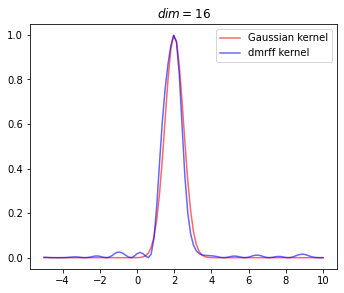

In [25]:
dm_rff_pdf = calc_rbf(dmrff, np.broadcast_to(mean, x.shape), x)
pl.plot(x, gauss_pdf, 'r-',  alpha=0.6, label='Gaussian kernel')
pl.plot(x, dm_rff_pdf, 'b-',  alpha=0.6, label='dmrff kernel')
pl.title("$dim = "+str(n_rffs)+"$")
pl.legend()

In [26]:
print(f'Mean: {np.mean(dmrff.rff_layer.rff_weights, axis=1)}')
print(f'Std: {np.std(dmrff.rff_layer.rff_weights, axis=1)}')
print(f'Gamma: {dmrff.rff_layer.gamma_val.numpy()}')

Mean: [-0.29038265]
Std: [0.96020234]
Gamma: 1.0


In [27]:
dmrff.predict(x_train), x_train.shape

(array([0.00890563, 0.0021974 , 0.0088729 , ..., 0.00714422, 0.00501961,
        0.01040566], dtype=float32), (2000, 2, 1))

## DMKDE for pdf Estimation

### (16x16) DMKDE Mixed State

In [28]:
def calculate_constant_qmkde(gamma=1):
  constant_kernel = (2*np.pi)**(-1/2)
  sigma = (4*gamma)**(-1/2)
  constant_outside = 1/(sigma)
  return constant_kernel * constant_outside

In [29]:
# ----------------------------------------------------------------------
# Plot a 1D density example
N = 1000
np.random.seed(0)
X = np.concatenate((np.random.normal(-1, 1, int(0.65 * N)),
                    np.random.normal(3, 1, int(0.35 * N))))[:, np.newaxis]

X_plot = np.linspace(-7, 7, 250)[:, np.newaxis]

true_dens = (0.65 * norm(-1, 1).pdf(X_plot[:, 0])
             + 0.35 * norm(3, 1).pdf(X_plot[:, 0]))

### DMKDE Tensorflow

In [39]:
qmkdc_dig = models.QMDensity(fm_x = dmrff.rff_layer, dim_x=n_rffs)
qmkdc_dig.compile()
qmkdc_dig.fit(X, epochs=1)
out = qmkdc_dig.predict(X_plot)

32/32 [==============================] - 0s 2ms/step


In [40]:
prob_expected_mixed = calculate_constant_qmkde(dmrff.rff_layer.gamma_val.numpy()) * out

Text(0, 0.5, 'Probability')

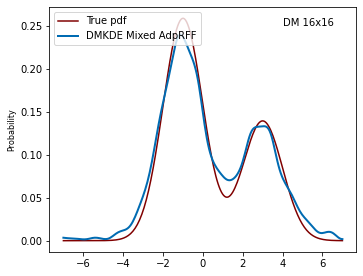

In [41]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot[:, 0], prob_expected_mixed, color='#006BB2', lw=lw,
            linestyle='-', label="DMKDE Mixed AdpRFF")    
plt.text(4, 0.25, f"DM {n_rffs}x{n_rffs}")
plt.legend(loc='upper left')
plt.xlabel('')
plt.ylabel('Probability')

### DMKDE Numpy

In [42]:
X_feat_train = dmrff.rff_layer.call(tf.cast(X, tf.float32))
X_feat_test = dmrff.rff_layer.call(tf.cast(X_plot, tf.float32))

X_feat_train = np.float64((X_feat_train).numpy())
X_feat_test = np.float64((X_feat_test).numpy())

X_feat_train = X_feat_train / np.linalg.norm(X_feat_train, axis = 1).reshape(-1, 1)
X_feat_test = X_feat_test / np.linalg.norm(X_feat_test, axis = 1).reshape(-1, 1)

X_feat_train.shape, X_feat_test.shape

((1000, 16), (250, 16))

In [43]:
n_rffs

16

In [44]:
## Training

rho_train = np.zeros((n_rffs, n_rffs))

for i in range(len(X_feat_train)):
  rho_train += np.outer(X_feat_train[i], X_feat_train[i])

rho_train = rho_train / len(X_feat_train)

(X_feat_train[0]**2).sum()

1.0000000000000002

In [45]:
## Expected result

prob_expected_mixed = np.zeros(250)

for i in range(len(prob_expected_mixed)):
  prob_expected_mixed[i] = X_feat_test[i].T @ rho_train @ X_feat_test[i]

prob_expected_mixed = calculate_constant_qmkde(dmrff.rff_layer.gamma_val.numpy()) * prob_expected_mixed

prob_expected_mixed.shape

(250,)

In [46]:
## Expected result

prob_expected_mixed = np.zeros(len(X_plot))

for i in range(len(prob_expected_mixed)):
  prob_expected_mixed[i] = X_feat_test[i].T @ rho_train @ X_feat_test[i]

prob_expected_mixed = calculate_constant_qmkde(2**(0)) * prob_expected_mixed

prob_expected_mixed.shape

(250,)

Text(0, 0.5, 'Probability')

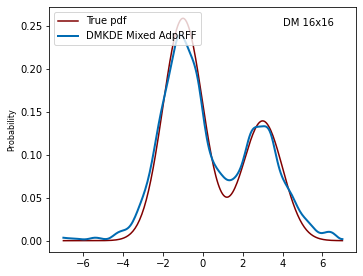

In [47]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot[:, 0], prob_expected_mixed, color='#006BB2', lw=lw,
            linestyle='-', label="DMKDE Mixed AdpRFF")    
plt.text(4, 0.25, f"DM 16x16")
plt.legend(loc='upper left')
plt.xlabel('')
plt.ylabel('Probability')

### DMKDE Mixed State Qiskit

In [ ]:
# Find eigenvectors and eigenvalues
lambda_train, U_train = np.linalg.eigh(rho_train)

lambda_train, U_train

(array([6.80651707e-16, 3.25733538e-11, 3.43821700e-10, 4.68417752e-07,
        1.88598303e-06, 3.55037925e-04, 4.89704657e-04, 9.11103166e-03,
        1.47662353e-02, 4.37572433e-02, 6.89238924e-02, 8.98806843e-02,
        1.04689434e-01, 1.64473339e-01, 1.80093822e-01, 3.23457221e-01]),
 array([[ 7.60689595e-04, -2.36704122e-03, -9.92419295e-02,
         -4.83644199e-02,  4.85418033e-01,  3.06581543e-01,
         -1.60602383e-01,  4.22217017e-01, -1.25971723e-01,
          6.62341560e-02, -1.24919210e-01,  3.69976208e-01,
         -2.50184499e-01,  4.51692558e-01,  8.60622389e-02,
         -8.57571875e-02],
        [ 4.30658093e-02,  6.52261138e-01, -1.52123887e-01,
         -4.34176532e-02, -7.98206397e-02, -2.28285461e-01,
         -2.00585258e-01, -2.65206960e-02, -4.06462886e-01,
         -5.97904157e-02, -1.29643010e-01,  3.80663078e-01,
          9.35867104e-02, -2.79557932e-01,  3.03555501e-02,
         -1.72972151e-01],
        [ 6.13271762e-01, -1.78804671e-01, -1.55021417e-

In [ ]:
# Predict with the quantum circuit
backend = Aer.get_backend('qasm_simulator')
prob_test_mixed = np.zeros(250)

exp_time = time()
for i in range(len(prob_test_mixed)):
  qc = QuantumCircuit(8, 4)
  qc.initialize(X_feat_test[i], [0, 1, 2, 3])
  qc.initialize(np.sqrt(lambda_train, dtype = np.float64), [4, 5, 6, 7])
  qc.isometry(U_train.T, [], [0, 1, 2, 3]) # ArbRot as a isometry
  qc.cnot(7, 3)
  qc.cnot(6, 2)
  qc.cnot(5, 1)
  qc.cnot(4, 0)
  qc.measure(0, 0)
  qc.measure(1, 1)
  qc.measure(2, 2)
  qc.measure(3, 3)
  counts = execute(qc, backend, shots=10000).result().get_counts()
  prob_zero = (counts["0000"]/10000)
  prob_test_mixed[i] = prob_zero
  if i % 10 == 0:
    print(i)
    print(time() - exp_time)
    exp_time = time()

0
10.688226222991943
10
103.42297601699829
20
109.86266803741455
30
96.10453081130981
40
96.6865611076355
50
96.590580701828
60
96.68273520469666
70
96.83170461654663
80
97.2377872467041
90
97.10063123703003
100
97.02487874031067
110
97.39143204689026
120
97.23411917686462
130
96.87007737159729
140
97.3459005355835
150
96.93035173416138
160
100.31564593315125
170
100.93188953399658
180
111.45109796524048
190
126.73202610015869
200
99.8668897151947
210
98.30355381965637
220
97.12805819511414
230
97.61074328422546
240
96.87469434738159


In [ ]:
prob_test_mixed_2 = calculate_constant_qmkde(dmrff.rff_layer.gamma_val.numpy()) * prob_test_mixed

Text(0, 0.5, 'Probability Density')

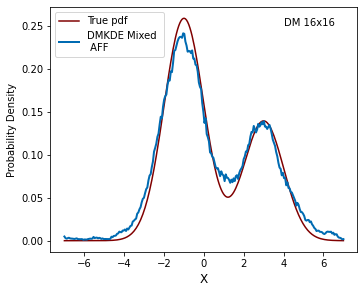

In [ ]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot[:, 0], prob_test_mixed_2, color='#006BB2', lw=lw,
            linestyle='-', label="DMKDE Mixed \n AFF")    
plt.text(4, 0.25, f"DM 16x16")
plt.legend(loc='upper left')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)

In [ ]:
#np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/mixedstate_qubits_16comp_adpRFF_gamma1fixed.npy", prob_test_mixed_2)
prob_test_mixed_3 = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/mixedstate_qubits_16comp_adpRFF_gamma1fixed.npy")

### DMKDE Pure State Qiskit

In [ ]:
def calculate_constant_qmkde_pure(gamma=1):
  constant_kernel = (2*np.pi)**(-1/2)
  sigma = (2*gamma)**(-1/2)
  constant_outside = 1/(sigma)
  return constant_kernel * constant_outside

In [ ]:
# Given the eigenvalues this function return a Unitary gate which converts the |0> -> |lambda>
def create_U_train(x_train_param, seed=0):
  #np.random.seed(seed)
  size_U = len(x_train_param)
  U_train = np.zeros((size_U, size_U))
  x_1 = x_train_param
  U_train[:, 0] = x_1
  for i in range(1, size_U):
    x_i = np.random.randn(size_U)
    for j in range(0, i):
      x_i -= x_i.dot(U_train[:, j]) * U_train[:, j]
    x_i = x_i/np.linalg.norm(x_i)
    U_train[:, i] = x_i
  
  return U_train

In [ ]:
## Training pure state and create the Unitary matrix to initialize such state

psi_train = X_feat_train.sum(axis = 0)
psi_train = psi_train / np.linalg.norm(psi_train)

U_train = create_U_train(psi_train)

(psi_train**2).sum()

1.0

In [ ]:
## Expected result 
psi_train_total = (X_feat_train.sum(axis = 0) / np.linalg.norm(X_feat_train.sum(axis = 0))).reshape(-1, 1)
prob_test_16_expected = X_feat_test @ psi_train_total
prob_test_16_expected = calculate_constant_qmkde_pure(dmrff.rff_layer.gamma_val.numpy()) * np.sqrt(prob_test_16_expected**2) * np.linalg.norm(X_feat_train.sum(axis = 0)) / 1000
psi_train_total.shape, X_feat_test.shape, prob_test_16_expected.shape

((16, 1), (250, 16), (250, 1))

Text(0, 0.5, 'Probability Density')

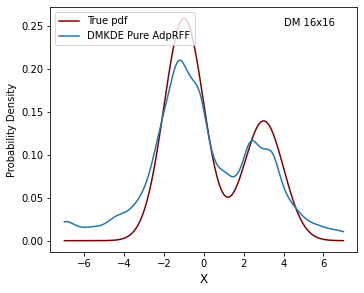

In [ ]:
# Expected result in a classical computer
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
#plt.plot(X_plot[:, 0], prob_test_16_expected.ravel(), color='green', lw=lw,
            # linestyle='-', label="DMKDE Pure")  
plt.plot(X_plot[:, 0], prob_test_16_expected.ravel(), label="DMKDE Pure AdpRFF") 
plt.text(4, 0.25, f"DM 16x16")
plt.legend(loc='upper left')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)

In [ ]:
# Predict with the pure state quantum circuit
prob_test = np.zeros(250)
backend = Aer.get_backend('qasm_simulator')
exp_time = time()

for i in range(len(prob_test)):
  #"""
  qc = QuantumCircuit(4, 4)
  qc.initialize(X_feat_test[i], [0, 1, 2, 3])
  qc.isometry(U_train.T, [], [0, 1, 2, 3]) # ArbRot as a isometry
  qc.measure(0, 0)
  qc.measure(1, 1)
  qc.measure(2, 2)
  qc.measure(3, 3)
  counts = execute(qc, backend, shots=10000).result().get_counts()
  try:
    prob_zero = (counts["0000"]/10000)
  except:
    prob_zero = 0
  prob_test[i] = prob_zero
  if i % 10 == 0:
    print(i)
    print(time() - exp_time)
    exp_time = time()

0
2.1645090579986572
10
19.241626977920532
20
24.76967477798462
30
18.77110481262207
40
18.345872402191162
50
18.968117713928223
60
20.73809838294983
70
18.633424282073975
80
18.55515480041504
90
18.838902950286865
100
18.662621021270752
110
17.629656076431274
120
17.81453800201416
130
18.075623750686646
140
17.940595626831055
150
17.309056520462036
160
18.008583545684814
170
18.015706300735474
180
18.119516372680664
190
17.9002902507782
200
18.359500408172607
210
18.22488260269165
220
17.942532539367676
230
17.79218864440918
240
17.64289903640747


In [ ]:
prob_test_pure = calculate_constant_qmkde_pure(dmrff.rff_layer.gamma_val.numpy()) * np.sqrt(prob_test) * (1/1000) * np.linalg.norm(X_feat_train.sum(axis = 0))

Text(0, 0.5, 'Probability Density')

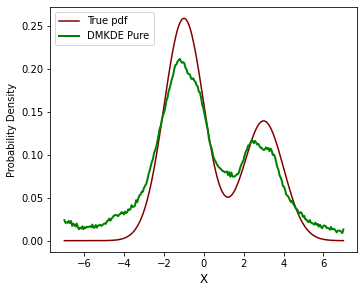

In [ ]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot[:, 0], prob_test_pure_3, color='green', lw=lw,
            linestyle='-', label="DMKDE Pure")    
#plt.text(4, 0.25, f"DM 16x16")
plt.legend(loc='upper left')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)

In [ ]:
#np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/purestate_qubits_16comp_adpRFF_gamma1fixed.npy", prob_test_pure)
prob_test_pure_3 = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/purestate_qubits_16comp_adpRFF_gamma1fixed.npy")

### Summary of Mixed and Pure Qiskit

In [ ]:
prob_test_pure_3 = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/purestate_qubits_16comp_adpRFF_gamma1fixed.npy")
prob_test_mixed_3 = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/mixedstate_qubits_16comp_adpRFF_gamma1fixed.npy")

Text(0, 0.5, 'Probability Density')

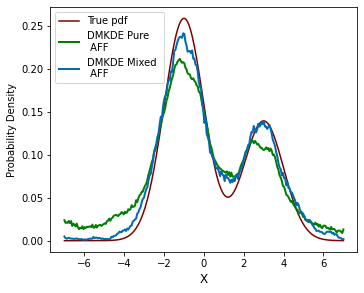

In [ ]:
params = {
   'axes.labelsize': 10,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot[:, 0], prob_test_pure_3, color='green', lw=lw,
            linestyle='-', label="DMKDE Pure \n AFF")  
plt.plot(X_plot[:, 0], prob_test_mixed_3, color='#006BB2', lw=lw,
            linestyle='-', label="DMKDE Mixed \n AFF") 
#plt.text(4, 0.25, f"DM 16x16")
plt.legend(loc='upper left')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)